In [1]:
using PauliPropagation
using Plots
using Printf
using LinearAlgebra
using LaTeXStrings
using ProgressMeter

In [2]:
function getnewimaginarypaulistring(gate::MaskedPauliRotation, pstr::PauliStringType)
    new_pstr, sign = pauliprod(gate.generator_mask, pstr, gate.qinds)
    return new_pstr, -1im * sign
end


function PauliPropagation.applytoall!(gate::PauliRotation, theta::ComplexF64, psum, aux_psum; kwargs...)
    # NOTE: This is for imaginary time evolution!
    if real(theta) > 0.0
        throw(ArgumentError("Parameter `theta` needs to be fully imaginary. Got theta=$theta"))
    end

    
    # turn the PauliRotation gate into a MaskedPauliRotation gate
    # this allows for faster operations
    gate = PauliPropagation._tomaskedpaulirotation(gate, paulitype(psum))

    # pre-compute the sinh and cosh values because they are used for every Pauli string that does not commute with the gate
    cosh_val = cos(theta)
    sinh_val = sin(theta)
    # loop over all Pauli strings and their coefficients in the Pauli sum
    for (pstr, coeff) in psum

        if !commutes(gate, pstr)
            # if the gate does not commute with the pauli string, do nothing
            continue
        end

        # else we know the gate will split the Pauli string into two
        coeff1 = real(coeff * cosh_val)
        new_pstr, sign = getnewimaginarypaulistring(gate, pstr)
        coeff2 = real(coeff * sinh_val * sign)

        # set the coefficient of the original Pauli string
        set!(psum, pstr, coeff1)

        # set the coefficient of the new Pauli string in the aux_psum
        # we can set the coefficient because PauliRotations create non-overlapping new Pauli strings
        set!(aux_psum, new_pstr, coeff2)
    end

    return
end


function PauliPropagation.applymergetruncate!(gate, psum, aux_psum, thetas, param_idx; max_weight=Inf, min_abs_coeff=1e-10, max_freq=Inf, max_sins=Inf, customtruncfunc=nothing, normalization=false, kwargs...)

    # Pick out the next theta if gate is a ParametrizedGate.
    # Else set the paramter to nothing for clarity that theta is not used.
    if gate isa ParametrizedGate
        theta = thetas[param_idx]
        # If the gate is parametrized, decrement theta index by one.
        param_idx -= 1
    else
        theta = nothing
    end
    # Apply the gate to all Pauli strings in psum, potentially writing into auxillary aux_psum in the process.
    # The pauli sums will be changed in-place
    applytoall!(gate, theta, psum, aux_psum; kwargs...)
    
    # Any contents of psum and aux_psum are merged into the larger of the two, which is returned as psum.
    # The other is emptied and returned as aux_psum.
    psum, aux_psum = mergeandempty!(psum, aux_psum)

    nq = psum.nqubits    
    if normalization
        min_abs_coeff = min_abs_coeff * getcoeff(psum, :I, 1)
    end
    
    # Check truncation conditions on all Pauli strings in psum and remove them if they are truncated.
    PauliPropagation.checktruncationonall!(psum; max_weight, min_abs_coeff, max_freq, max_sins, customtruncfunc)

    return psum, aux_psum, param_idx
end

In [3]:
function freeEnergyTFIM(M::Matrix{Float64}, beta::Float64)
    eigvals = eigen(Hermitian(M)).values
    F = - (1 / (2 * beta)) * sum(log.(2 .* cosh.(beta .* eigvals)))
    return F
end

function energyTFIM(M::Matrix{Float64}, beta::Float64)
    eigvals = eigen(Hermitian(M)).values
    positive_eigvals = eigvals[eigvals .> 0]
    nk = 1 ./ (1 .+ exp.(2* beta .* positive_eigvals))
    return sum(positive_eigvals .* (2* nk .- 1))
end

function jordan_wigner_tfim(n_sites::Int, Jx::Float64=1.0, Jy::Float64=1.0, h::Float64=1.0)
    """
    Construct the Bogoliubov-de Gennes matrix for the Ising model:

    Args:
        n_sites (Int): Number of sites
        J (Float64): Coupling strength for σ^x σ^x interaction
        h (Float64): Transverse field strength

    Returns:
        Matrix{Float64}: 2n_sites × 2n_sites BdG matrix
    """
    J = Jx+Jy
    k = (Jx-Jy)/J
    A = zeros(Float64, n_sites, n_sites)
    B = zeros(Float64, n_sites, n_sites)

    for i in 1:(n_sites-1)
        A[i, i] = h
        A[i+1, i+1] = h
    end

    for i in 1:(n_sites-1)
        A[i, i+1] = -J/2
        A[i+1, i] = -J/2
    end

    for i in 1:(n_sites-1)
        B[i, i+1] = -J*k/2
        B[i+1, i] = J*k/2
    end

    M = [A  B;
        -B -A]

    return M
end

function zz_correlation(M::Matrix{Float64}, beta::Float64, i::Int, j::Int)
    N = size(M, 1) ÷ 2

    eigvals, eigvecs = eigen(Hermitian(M))

    # Extract u and v components
    Uk = eigvecs[1:N, :]
    Vk = eigvecs[N+1:end, :]

    # Thermal occupations
    f = 1.0 ./ (exp.(2 * beta .* eigvals) .+ 1.0)
    f_diag = Diagonal(f)

    G = Uk * f_diag * Uk'
    F = Uk * f_diag * Vk'

    zz = 4 * (G[i,i] - 0.5) * (G[j,j] - 0.5) - 4 * G[i,j] * G[j,i] + 4 * abs2(F[i,j])

    return zz
end

zz_correlation (generic function with 1 method)

In [4]:
function thermalStateExpectation(circuit, nl, nq, operator; max_weight=nq, min_abs_coeff=0)
    pstr = PauliString(nq, :I, 1)
    psum = PauliSum(pstr)

    expectations = Float64[]

    @showprogress for layers in 1:nl
        psum = propagate!(circuit, psum; max_weight, min_abs_coeff, normalization=true)
        
        # the extra division is the also rescale expectations without continually dividing trough
        expectation = getcoeff(psum, operator) / getcoeff(psum, pstr)
        expectations = push!(expectations, expectation)
    end
    return expectations
end

function freeEnergyPP(circuit, nl, nq, beta; max_weight=nq, min_abs_coeff=0)
    pstr = PauliString(nq, :I, 1)
    psum = PauliSum(pstr)

    freeEnergies = Float64[]
    betas = range(beta, beta*nl, length=nl)
    @showprogress for layers in 1:nl
        psum = propagate!(circuit, psum; max_weight, min_abs_coeff, normalization=true)
        normalization = getcoeff(psum, pstr)
        freeEnergy = -log(2^nq*normalization)/betas[layers]
        freeEnergies = push!(freeEnergies, freeEnergy)
    end
    return freeEnergies
end

function energyExpectationPP(circuit, nl, nq, h; max_weight=nq, min_abs_coeff=0)
    pstr = PauliString(nq, :I, 1)
    psum = PauliSum(pstr)

    energies = Float64[]

    @showprogress for layers in 1:nl
        energyLayer = 0
        psum = propagate!(circuit, psum; max_weight, min_abs_coeff, normalization=true)
        Z = getcoeff(psum, pstr)
        for operator in h
            energy = operator.coeff*getcoeff(psum, operator)
            energyLayer += energy
        end
        energies = push!(energies, energyLayer/Z)
    end
    return energies
end

function XMatrix(n::Int, i::Int)
    Xmat = [0 1; 1 0]
    Imat = [1 0; 0 1]

    operator = (i == 1) ? Xmat : Imat

    for j in 2:n
        if j == i
            operator = kron(operator, Xmat)
        else
            operator = kron(operator, Imat)
        end
    end
    
    return operator
end

function YMatrix(n::Int, i::Int)
    Ymat = [0 -im; im 0]
    Imat = [1 0; 0 1]

    operator = (i == 1) ? Ymat : Imat

    for j in 2:n
        if j == i
            operator = kron(operator, Ymat)
        else
            operator = kron(operator, Imat)
        end
    end
    
    return operator
end

function ZMatrix(n::Int, i::Int)
    Zmat = [1 0; 0 -1]
    Imat = [1 0; 0 1]

    operator = (i == 1) ? Zmat : Imat

    for j in 2:n
        if j == i
            operator = kron(operator, Zmat)
        else
            operator = kron(operator, Imat)
        end
    end
    
    return operator
end

function imaginaryTimeEvolution(h::Matrix, beta::Float64)
    operator = exp(-beta*h)
    return operator/tr(exp(-beta*h))
end

function freeEnergy(h::Matrix, beta::Float64)
    Z = tr(exp(-beta*h))
    return -log(Z)/beta
end

function energyExact(h::Matrix, beta::Float64)
    thermal = exp(-beta*h)/tr(exp(-beta*h))
    energy = tr(thermal*h)
    return energy
end

energyExact (generic function with 1 method)

In [5]:
theta = 0.01im
θ = theta
nq = 30

topology = bricklayertopology(nq)

# the circuit
circuit = Gate[]
nl = 1
for i in 1:nl
    #append!(circuit, PauliRotation(:X, ii, θ) for ii in 1:nq);
    append!(circuit, PauliRotation(:Z, ii, θ) for ii in 1:nq);
    append!(circuit, PauliRotation([:X, :X], pair, θ) for pair in topology);
end


In [6]:
h = zeros(Float64, 2^nq, 2^nq)
for i in 1:nq
    h += ZMatrix(nq, i)
    if i < nq
        h += XMatrix(nq, i) * XMatrix(nq, i+1)
    end
end

energy = energyExact(h, 10.0)
M = jordan_wigner_tfim(nq, -1.0, 0.0, -1.0)   
energyTF = energyTFIM(M, 10.0)
println("Exact energy: ", energy)
println("TFIM energy: ", energyTF)

Exact energy: -12.367044988937232
TFIM energy: -12.367044988937236


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:13
Progress: 100%|█████████████████████████████████████████| Time: 0:00:26


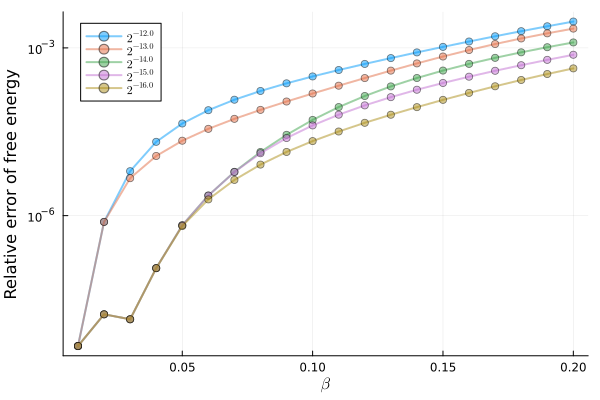

In [6]:

nl = 20
betas = range(imag(theta), imag(theta)*nl, length=nl)

M = jordan_wigner_tfim(nq, -1.0, 0.0, -1.0)


Fexact = zeros(ComplexF64, length(betas))
for i in 1:length(betas)
    Fexact[i] = freeEnergyTFIM(M, betas[i])
end
plot(ylabel="Relative error of free energy", xlabel=L"\beta")

trunc_coeffs = 2.0 .^ (-12:-1:-16)
for j in trunc_coeffs
    Fpp = freeEnergyPP(circuit, nl, nq, imag(theta); max_weight=9, min_abs_coeff=j)
    error = abs.((Fexact - Fpp)./Fexact) 
    plot!(betas, error, label = L"$2^{%$(round(log2(j), digits=2))}$", legend=:topleft, lw=2, markersize=4, marker=:circle, alpha=0.5)
end

plot!(yscale=:log10)

display(plot!())

In [7]:
theta = 0.01im
θ = theta
nq = 30

topology = bricklayertopology(nq)

# the circuit
circuit = Gate[]
nl = 1
for i in 1:nl
    #append!(circuit, PauliRotation(:X, ii, θ) for ii in 1:nq);
    append!(circuit, PauliRotation(:Z, ii, 2*θ) for ii in 1:nq);
    append!(circuit, PauliRotation([:X, :X], pair, 1*θ) for pair in topology);
end


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:01:53
Progress: 100%|█████████████████████████████████████████| Time: 0:06:16


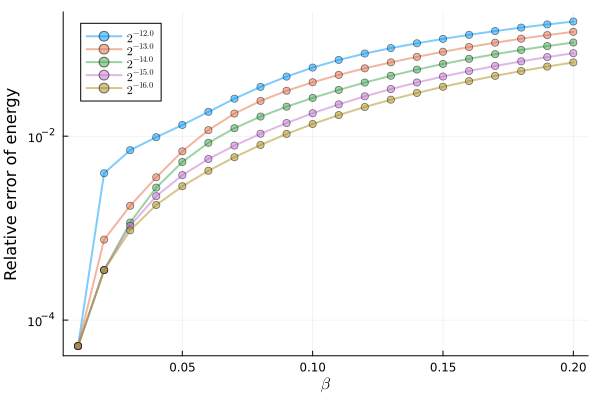

In [8]:
h = []
for i in 1:nq
    push!(h, PauliString(nq, :Z, i, -2))
    if i < nq
        push!(h, PauliString(nq, [:X, :X], (i, i+1), -1.0))
    end
end

nl = 20

betas = range(imag(theta), imag(theta)*nl, length=nl)
M = jordan_wigner_tfim(nq, 1.0, 0.0, 2.0)
Eexact = zeros(ComplexF64, length(betas))
for i in 1:length(betas)
    Eexact[i] = energyExact(M, betas[i])
end
trunc_coeffs = 2.0 .^ (-12:-1:-16)
plot(ylabel="Relative error of energy", xlabel=L"\beta")
for j in trunc_coeffs
    Epp = energyExpectationPP(circuit, nl, nq, h; max_weight=9, min_abs_coeff=j)
    error = abs.((Eexact - Epp/nq)./Eexact)
    plot!(betas, error, label = L"$2^{%$(round(log2(j), digits=2))}$", legend=:topleft, lw=2, markersize=4, marker=:circle, alpha=0.5)

end
plot!(yscale=:log10)
display(plot!())
